# Getting Started with Syne Tune

This notebook shows how to get started with Syne Tune. We will use a simple toy example here, for which tuning runs locally (and does not need a GPU).

## Setup

Install Syne Tune

In [5]:
!pip install 'syne-tune'

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


This install a bare-bones version of Syne Tune, sufficient to run this notebook.
* `pip install 'syne-tune'[gpsearchers]` installs a number of built-in Gaussian process HPO methods
* `pip install 'syne-tune'[extra]` installs everything, including Ray (for Ray Tune optimizers)

## Training Script

For a start, we need a training script, as will be familiar to SageMaker users. We will use `train_height.py`. Tuning is enabled by reporting metric values back to Syne Tune. If training is iterative, you should report at the end of each iteration (e.g., epoch in neural network training).

In [ ]:
# train_height.py
import logging
import time

from syne_tune import Reporter
from argparse import ArgumentParser

if __name__ == '__main__':
    root = logging.getLogger()
    root.setLevel(logging.INFO)

    parser = ArgumentParser()
    parser.add_argument('--steps', type=int)
    parser.add_argument('--width', type=float)
    parser.add_argument('--height', type=float)

    args, _ = parser.parse_known_args()
    report = Reporter()

    for step in range(args.steps):
        mean_loss = (0.1 + args.width * step / 100) ** (-1) + args.height * 0.1
        # Feed the score back to Syne Tune.
        report(mean_loss=mean_loss, epoch=step + 1)
        time.sleep(0.1)

## Run Tuning Locally

This script comes with hyperparameters `width` and `height`, whereas `steps` is the maximum number of iterations. While the training script provides the function to be tuned, we need to define a domain for the search. This is done by a *configuration space*.

For each hyperparameter, we define a type and range. In our example, both `width` and `height` are integers uniformly distributed between 1 and 20.

In [6]:
import logging

from syne_tune import Tuner, StoppingCriterion
from syne_tune.backend import LocalBackend
from syne_tune.config_space import randint
from syne_tune.optimizer.baselines import ASHA

logging.getLogger().setLevel(logging.INFO)


# Configuration space
config_space = {
    'width': randint(1, 20),
    'height': randint(1, 20),
    'steps': 100,
}

Next, we create the components required for tuning:
* The trial backend executing the trainings. We use the local backend, which runs training jobs as subprocesses
* The scheduler which contains the logic of the HPO algorithm. We use asynchronous successive halving
* The tuner which coordinates these two, runs the experiments and records result data

In [7]:
trial_backend = LocalBackend(entry_point='train_height.py')

scheduler = ASHA(
    config_space,
    metric='mean_loss',  # name of metric to tune
    mode='min',  # should be minimized
    resource_attr='epoch',  # name of resource parameter (epochs in our example)
    max_resource_attr='steps',  # config_space attribute for maximum number of epochs
    search_options={'debug_log': False},  # suppress verbose log output
)

tuner = Tuner(
    trial_backend=trial_backend,
    scheduler=scheduler,
    stop_criterion=StoppingCriterion(max_wallclock_time=45),  # run for 45 secs
    n_workers=4,  # how many trials are evaluated in parallel
)

tuner.run()

INFO:syne_tune.optimizer.schedulers.searchers.utils.default_arguments:scheduler_options: Key 'resume': Imputing default value False
scheduler_options: Key 'grace_period': Imputing default value 1
scheduler_options: Key 'reduction_factor': Imputing default value 3
scheduler_options: Key 'brackets': Imputing default value 1
scheduler_options: Key 'type': Imputing default value stopping
scheduler_options: Key 'searcher_data': Imputing default value rungs
scheduler_options: Key 'register_pending_myopic': Imputing default value False
scheduler_options: Key 'do_snapshots': Imputing default value False
scheduler_options: Key 'rung_system_per_bracket': Imputing default value False
scheduler_options: Key 'rung_system_kwargs': Imputing default value {'cost_attr': 'elapsed_time', 'ranking_criterion': 'soft_ranking', 'epsilon': 1.0, 'epsilon_scaling': 1.0}
INFO:syne_tune.optimizer.schedulers.fifo:max_resource_level = 100, as inferred from config_space
INFO:syne_tune.optimizer.schedulers.fifo:Maste

--------------------
Resource summary (last result is reported):
 trial_id      status  iter  width  height  steps  step  mean_loss  epoch  worker-time
        0   Completed   100     10      10    100  99.0   1.100000  100.0     9.930432
        1     Stopped    37      2      12    100  36.0   2.419512   37.0     3.612111
        2     Stopped    38      3      19    100  37.0   2.726446   38.0     3.711288
        3     Stopped    37     11      14    100  36.0   1.646305   37.0     3.611176
        4     Stopped    39     20      17    100  38.0   1.829870   39.0     3.811702
        5   Completed   100     11       7    100  99.0   0.790992  100.0     9.929597
        6   Completed   100     13       4    100  99.0   0.477101  100.0     9.931138
        7     Stopped    43     15      20    100  42.0   2.156250   43.0     4.213685
        8     Stopped    42      6       1    100  41.0   0.490625   42.0     4.113279
        9     Stopped    42      5       8    100  41.0   1.26511

## Plot Results

The results of an experiment are stored to a dataframe, which contains all metrics received (with time stamps) and their configurations. Based on this data, we can plot the best value found over time.

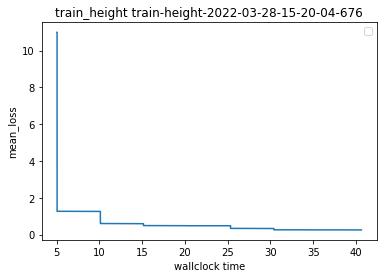

In [8]:
from syne_tune.experiments import load_experiment

tuning_experiment = load_experiment(tuner.name)
tuning_experiment.plot()